# Discovering a Parent Hamiltonian using Modern Qiskit Primitives

## Overview
This notebook simulates a sophisticated scenario to discover the parent Hamiltonian of a quantum state. This version is updated to use the modern **`EstimatorV2`** primitive from Qiskit Aer, which is the current standard and avoids deprecation warnings.

The process is as follows:
1.  **Generate a State Preparation Circuit:** We create a `QuantumCircuit` for a generic state `|psi>`.
2.  **Define Parameterized Projectors:** We define a parameterized unitary `U(theta)` and a static base projector $P_{base}$.
3.  **Optimize Projectors via VQA:** A classical optimizer (COBYLA) seeks parameters `theta` to minimize the expectation value $\langle\psi|P(theta)|\psi\rangle$. The `EstimatorV2`, configured to use an MPS-based `AerSimulator`, efficiently calculates this value.
4.  **Construct Parent Hamiltonian:** The Hamiltonian $H$ is built by summing the optimized projectors $P^*$.
5.  **Verification:** We find the ground state of $H$ and verify its fidelity with the original state `|psi>`.

## 1. Imports and Setup

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, state_fidelity
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_aer import AerSimulator # <-- Import the simulator itself
import itertools 
import time

try:
    from scipy.optimize import minimize
except ModuleNotFoundError:
    print("ERROR: scipy is not installed. Please install it: pip install scipy")
    def minimize(*args, **kwargs):
        raise RuntimeError("scipy.optimize.minimize not found. Please install scipy.")

## 2. Configuration Parameters

In [2]:
# --- Main Experiment Configuration ---
NUM_QUBITS = 11
PROJECTOR_QUBIT_COUNT = 5
PROJECTOR_RANK = 2**(PROJECTOR_QUBIT_COUNT - 1)

# --- State, Ansatz, and Optimizer Configuration ---
PSI_ANSATZ_DEPTH = 2
PROJECTOR_U_REPS = PROJECTOR_QUBIT_COUNT - 1 
SCIPY_COBYLA_MAXITER = 40000
SCIPY_COBYLA_TOL = 1e-4
SEED = 42

np.random.seed(SEED)
print(f"--- Discovering Parent Hamiltonian using MPS Simulation ---")
print(f"Config: Qubits={NUM_QUBITS}, Proj_Size={PROJECTOR_QUBIT_COUNT}, Proj_Rank={PROJECTOR_RANK}")

--- Discovering Parent Hamiltonian using MPS Simulation ---
Config: Qubits=11, Proj_Size=5, Proj_Rank=16


## 3. Step 1: Generate the State Preparation Circuit

Step 1: Generating the state preparation circuit |psi_initial>...
  Circuit for |psi_initial> created with 33 parameters and decomposed for simulation.


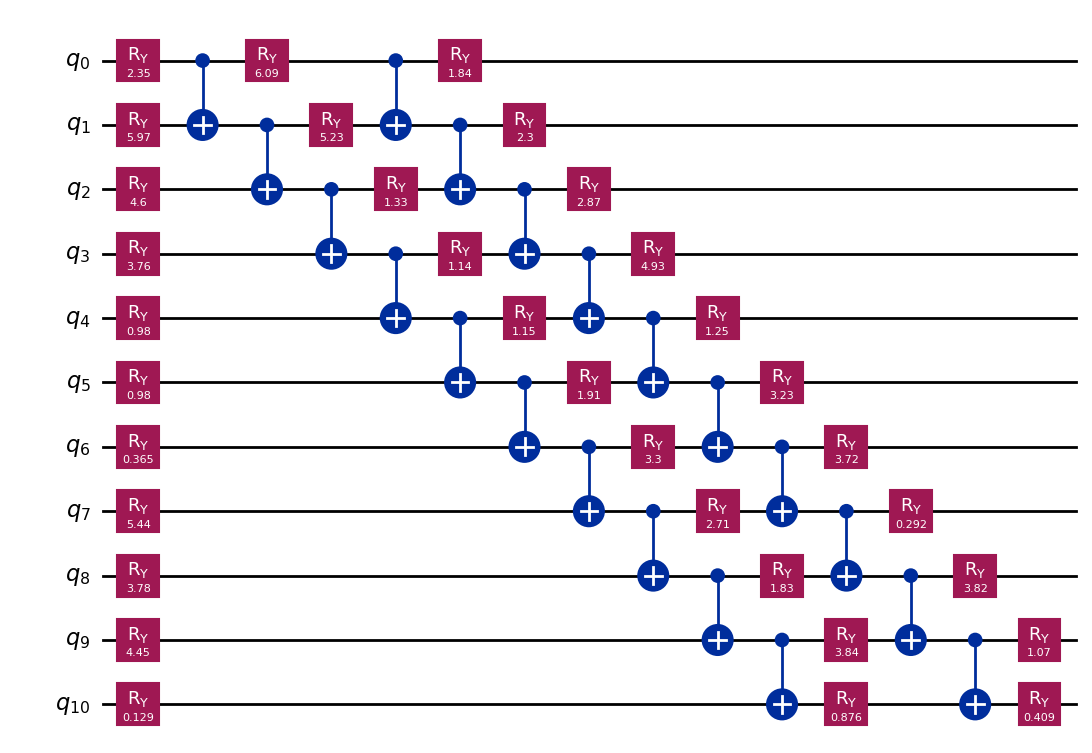

In [3]:
print("Step 1: Generating the state preparation circuit |psi_initial>...")
psi_ansatz = RealAmplitudes(NUM_QUBITS, reps=PSI_ANSATZ_DEPTH, entanglement='linear')
psi_params = np.random.rand(psi_ansatz.num_parameters) * 2 * np.pi
psi_preparation_circuit_unbound = psi_ansatz.assign_parameters(psi_params)
psi_preparation_circuit_unbound.name = "|psi>"

psi_preparation_circuit = psi_preparation_circuit_unbound.decompose()

print(f"  Circuit for |psi_initial> created with {psi_ansatz.num_parameters} parameters and decomposed for simulation.")

from qiskit.visualization import circuit_drawer
display(psi_preparation_circuit.draw('mpl'))

## 4. Step 2: Variational Optimization using `EstimatorV2`

In [ ]:
def run_optimization_with_mps(
    num_qubits, 
    psi_preparation_circuit, 
    proj_qubit_count, 
    proj_u_reps, 
    run_seed,
    optimizer_tol,
    optimizer_maxiter
):
    """
    Finds the optimized projectors P* using the modern EstimatorV2 with an MPS simulator,
    initialized according to the official documentation.
    """
    np.random.seed(run_seed)
    
    # --- CORRECTED INITIALIZATION FOR EstimatorV2 ---
    # The `method` and `seed` are passed inside the `options` dictionary,
    # under the `backend_options` and `run_options` keys respectively.
    estimator = AerEstimator(
        options={
            "backend_options": {
                "method": "matrix_product_state"
            },
            "run_options": {
                "shots": 10000,  # Use exact MPS contraction
                "seed": run_seed
            }
        }
    )

    print("\n[Step 2: Defining and Optimizing Projectors via MPS Simulation]")
    qubit_groups = [tuple((i + j) % num_qubits for j in range(proj_qubit_count)) for i in range(num_qubits)]
    
    u_ansatz = TwoLocal(proj_qubit_count, ['ry', 'rz'], 'cx', 'linear', reps=proj_u_reps)
    num_u_params = u_ansatz.num_parameters
    
    optimized_projectors = []
    for q_group in qubit_groups:
        q_group_str = "".join(map(str, q_group))
        print(f"\n  Optimizing projector for group {q_group}...")

        vqa_circuit = psi_preparation_circuit.compose(u_ansatz.inverse(), qubits=list(q_group))
        vqa_circuit = vqa_circuit.decompose()
        s_i_full = ['I'] * num_qubits
        s_z_full_list = ['I'] * num_qubits
        for q_idx in q_group: s_z_full_list[q_idx] = 'Z'
        base_projector_spo = SparsePauliOp([
            "".join(s_i_full)[::-1],
            "".join(s_z_full_list)[::-1]
        ], coeffs=[0.5, 0.5])

        def cost_func(params):
            # Create a Primitive Unified Bloc (PUB)
            pub = (vqa_circuit, base_projector_spo, params)
            
            # The estimator runs the PUB and returns the result.
            job = estimator.run(pubs=[pub]) # Shots and seed are already set in options
            result = job.result()
            cost = result[0].data.evs
            
            print(f"    Cost for P_{q_group_str}: {cost:.6e}", end='\r')
            return np.real(cost)

        init_params = np.random.rand(num_u_params) * 2 * np.pi
        try:
            opt_res = minimize(
                fun=cost_func, x0=init_params, method='COBYLA',
                tol=optimizer_tol, options={'maxiter': optimizer_maxiter, 'disp': False}
            )
            
            print(f"\n    Optimization finished. Final cost: {opt_res.fun:.6e}")

            u_circ_opt = u_ansatz.assign_parameters(opt_res.x)
            u_op_opt = Operator(u_circ_opt)
            identity_full = Operator(np.eye(2**num_qubits))
            u_op_full = identity_full.compose(u_op_opt, qargs=list(q_group))
            p_star_op = u_op_full.adjoint().compose(base_projector_spo).compose(u_op_full)
            optimized_projectors.append(p_star_op)
            
        except Exception as e_opt:
            print(f"    ERROR: An exception occurred during optimization for P_{q_group_str}: {e_opt}")
            
    return optimized_projectors

# Run the main optimization function
optimized_projectors_P_star = run_optimization_with_mps(
    NUM_QUBITS, psi_preparation_circuit, PROJECTOR_QUBIT_COUNT, 
    PROJECTOR_U_REPS, SEED, 
    SCIPY_COBYLA_TOL, SCIPY_COBYLA_MAXITER
)


[Step 2: Defining and Optimizing Projectors via MPS Simulation]

  Optimizing projector for group (0, 1, 2, 3, 4)...
    Cost for P_01234: 7.980028e-04
    Optimization finished. Final cost: 7.979956e-04

  Optimizing projector for group (1, 2, 3, 4, 5)...
    Cost for P_12345: 5.973706e-03
    Optimization finished. Final cost: 5.973706e-03

  Optimizing projector for group (2, 3, 4, 5, 6)...
    Cost for P_23456: 5.911930e-02
    Optimization finished. Final cost: 5.911928e-02

  Optimizing projector for group (3, 4, 5, 6, 7)...
    Cost for P_34567: 8.149900e-03
    Optimization finished. Final cost: 8.149834e-03

  Optimizing projector for group (4, 5, 6, 7, 8)...
    Cost for P_45678: 6.304079e-02
    Optimization finished. Final cost: 6.304079e-02

  Optimizing projector for group (5, 6, 7, 8, 9)...
    Cost for P_56789: 1.266273e-02
    Optimization finished. Final cost: 1.266273e-02

  Optimizing projector for group (6, 7, 8, 9, 10)...


## 5. Step 3: Construct Hamiltonian and Verify Result

In [ ]:
print("\n[Step 3: Finding Ground State of Discovered Hamiltonian]")

if not optimized_projectors_P_star:
    print("Warning: No projectors were successfully optimized. Cannot test the claim.")
else:
    print("Constructing Hamiltonian H = sum(P*)...")
    H_op = np.zeros((2**NUM_QUBITS, 2**NUM_QUBITS), dtype=np.complex128)
    for p_star in optimized_projectors_P_star:
        H_op += p_star.to_matrix()
    
    print("Diagonalizing Hamiltonian matrix...")
    eigenvalues, eigenvectors = np.linalg.eigh(H_op)
    
    ground_state_energy = eigenvalues[0]
    psi_gs_vector = Statevector(eigenvectors[:, 0])

    print(f"  Discovered Hamiltonian's Ground State Energy: {ground_state_energy:.6e}")
    
    if len(eigenvalues) > 1:
        energy_gap = eigenvalues[1] - eigenvalues[0]
        print(f"  Energy gap to first excited state: {energy_gap:.6f}")
        if energy_gap > 1e-9:
            print("  Ground state appears to be UNIQUE.")
        else:
            print("  Ground state appears to be DEGENERATE.")
    
    print("\n--- Claim Test Result ---")
    psi_initial_vector = Statevector(psi_preparation_circuit)
    fidelity = state_fidelity(psi_initial_vector, psi_gs_vector)
    
    print(f"Fidelity( |psi_initial>, |found_GS> ): {fidelity:.8f}")
    


[Step 3: Finding Ground State of Discovered Hamiltonian]
Constructing Hamiltonian H = sum(P*)...
Diagonalizing Hamiltonian matrix...
  Discovered Hamiltonian's Ground State Energy: 1.538089e-01
  Energy gap to first excited state: 0.010739
  Ground state appears to be UNIQUE.

--- Claim Test Result ---
Fidelity( |psi_initial>, |found_GS> ): 0.54210667
